# CartPole solver using an actor-critic (AC) agent

In [11]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# import os
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# import warnings
# warnings.filterwarnings('error', message=r".*complex128.*")
# warnings.simplefilter('module')

# from silence_tensorflow import silence_tensorflow
# silence_tensorflow()

import eqmarl
import matplotlib.pyplot as plt
import gymnasium as gym
from tensorflow import keras
import tensorflow as tf

In [13]:
# # Disable GPUs.
# tf.config.set_visible_devices([], 'GPU')

# List any available GPUs.
tf.config.list_physical_devices('GPU')

[]

In [16]:
# Quantum actor.
n_layers = 5
n_actions = 2
model_actor = eqmarl.generate_model_CartPole_actor_quantum(
    n_layers=n_layers,
    squash_activation='arctan',
    name='actor-quantum',
    )


# optimizer_actor = keras.optimizers.Adam(learning_rate=0.1)
optimizer_actor = [
    tf.keras.optimizers.Adam(learning_rate=0.01, amsgrad=True),
    tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True),
    tf.keras.optimizers.Adam(learning_rate=0.1, amsgrad=True),
]

model_actor.build((None, 4))
model_actor.summary()

Model: "actor-quantum"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input-preprocess (Sequentia  (None, 4, 1)             0         
 l)                                                              
                                                                 
 HybridVariationalEncodingPQ  (None, 2)                92        
 C (HybridVariationalEncodin                                     
 gPQC)                                                           
                                                                 
 observables-policy (Sequent  (None, 2)                2         
 ial)                                                            
                                                                 
Total params: 94
Trainable params: 94
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Classical critic.
model_critic = eqmarl.generate_model_critic_classical(
    units=[128, 64, 32],
    name=f"critic-classical",
    )

optimizer_critic = keras.optimizers.Adam(learning_rate=0.001)

model_critic.build((None, 4))
model_critic.summary()

Model: "critic-classical"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 4)                 0         
                                                                 
 dense_3 (Dense)             (None, 128)               640       
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 32)                2080      
                                                                 
 v (Dense)                   (None, 1)                 33        
                                                                 
Total params: 11,009
Trainable params: 11,009
Non-trainable params: 0
_________________________________________________________________


## Training

In [18]:
gamma = 0.99
agent = eqmarl.agents.AC(
    model_actor=model_actor,
    model_critic=model_critic,
    optimizer_actor=optimizer_actor,
    optimizer_critic=optimizer_critic,
    n_actions=n_actions,
    gamma=gamma,
)

In [19]:
env = gym.make('CartPole-v1')
trainer = eqmarl.trainers.GymTrainer(env=env)

n_episodes = 1000

metrics_history = trainer.train(
    n_episodes=n_episodes,
    agent=agent,
    reward_termination_threshold=500, # Stop after reward reaches threshold.
    report_interval=10,
    )

Training for 1000 episodes, press 'Ctrl+C' to terminate early


Episode 0:   0%|          | 0/1000 [00:00<?, ?episode/s]

Episode 10:   1%|          | 9/1000 [00:02<04:31,  3.64episode/s, episode_reward=16]

Episode 10/1000, average last 10 rewards 18.600000381469727


Episode 20:   2%|▏         | 19/1000 [00:05<04:48,  3.41episode/s, episode_reward=31]

Episode 20/1000, average last 10 rewards 27.200000762939453


Episode 30:   3%|▎         | 29/1000 [00:09<05:28,  2.96episode/s, episode_reward=68]

Episode 30/1000, average last 10 rewards 38.099998474121094


Episode 40:   4%|▍         | 39/1000 [00:13<05:03,  3.16episode/s, episode_reward=49] 

Episode 40/1000, average last 10 rewards 38.099998474121094


Episode 50:   5%|▍         | 49/1000 [00:19<07:49,  2.03episode/s, episode_reward=106]

Episode 50/1000, average last 10 rewards 51.70000076293945


Episode 60:   6%|▌         | 59/1000 [00:26<12:18,  1.27episode/s, episode_reward=51] 

Episode 60/1000, average last 10 rewards 67.5


Episode 70:   7%|▋         | 69/1000 [00:36<22:09,  1.43s/episode, episode_reward=104]

Episode 70/1000, average last 10 rewards 113.4000015258789


Episode 80:   8%|▊         | 79/1000 [00:51<20:29,  1.33s/episode, episode_reward=80] 

Episode 80/1000, average last 10 rewards 154.3000030517578


Episode 90:   9%|▉         | 89/1000 [01:15<40:51,  2.69s/episode, episode_reward=307]

Episode 90/1000, average last 10 rewards 267.6000061035156


Episode 100:  10%|▉         | 99/1000 [01:29<21:45,  1.45s/episode, episode_reward=143]

Episode 100/1000, average last 10 rewards 146.1999969482422


Episode 110:  11%|█         | 109/1000 [01:44<24:43,  1.67s/episode, episode_reward=140]

Episode 110/1000, average last 10 rewards 146.39999389648438


Episode 120:  12%|█▏        | 119/1000 [02:04<28:42,  1.95s/episode, episode_reward=185]

Episode 120/1000, average last 10 rewards 184.1999969482422


Episode 130:  13%|█▎        | 129/1000 [02:32<49:37,  3.42s/episode, episode_reward=464]

Episode 130/1000, average last 10 rewards 316.1000061035156


Episode 140:  14%|█▍        | 139/1000 [02:49<23:13,  1.62s/episode, episode_reward=129]

Episode 140/1000, average last 10 rewards 168.3000030517578


Episode 150:  15%|█▍        | 149/1000 [03:01<17:15,  1.22s/episode, episode_reward=123]

Episode 150/1000, average last 10 rewards 123.9000015258789


Episode 160:  16%|█▌        | 159/1000 [03:10<13:01,  1.08episode/s, episode_reward=13] 

Episode 160/1000, average last 10 rewards 81.19999694824219


Episode 170:  17%|█▋        | 169/1000 [03:20<13:14,  1.05episode/s, episode_reward=126]

Episode 170/1000, average last 10 rewards 97.9000015258789


Episode 180:  18%|█▊        | 179/1000 [03:33<17:39,  1.29s/episode, episode_reward=160]

Episode 180/1000, average last 10 rewards 120.80000305175781


Episode 190:  19%|█▉        | 189/1000 [03:47<20:00,  1.48s/episode, episode_reward=165]

Episode 190/1000, average last 10 rewards 138.10000610351562


Episode 200:  20%|█▉        | 199/1000 [04:03<19:17,  1.45s/episode, episode_reward=162]

Episode 200/1000, average last 10 rewards 157.6999969482422


Episode 210:  21%|██        | 209/1000 [04:20<21:19,  1.62s/episode, episode_reward=186]

Episode 210/1000, average last 10 rewards 177.8000030517578


Episode 220:  22%|██▏       | 219/1000 [04:40<27:59,  2.15s/episode, episode_reward=69] 

Episode 220/1000, average last 10 rewards 206.1999969482422


Episode 230:  23%|██▎       | 229/1000 [05:11<41:39,  3.24s/episode, episode_reward=213]

Episode 230/1000, average last 10 rewards 374.6000061035156


Episode 240:  24%|██▍       | 239/1000 [05:47<52:52,  4.17s/episode, episode_reward=102]

Episode 240/1000, average last 10 rewards 411.20001220703125


Episode 250:  25%|██▍       | 249/1000 [06:09<22:01,  1.76s/episode, episode_reward=167]

Episode 250/1000, average last 10 rewards 227.1999969482422


Episode 260:  26%|██▌       | 259/1000 [06:45<46:59,  3.81s/episode, episode_reward=251]

Episode 260/1000, average last 10 rewards 408.79998779296875


Episode 270:  27%|██▋       | 269/1000 [07:03<22:04,  1.81s/episode, episode_reward=164]

Episode 270/1000, average last 10 rewards 171.89999389648438


Episode 280:  28%|██▊       | 279/1000 [07:16<15:30,  1.29s/episode, episode_reward=64] 

Episode 280/1000, average last 10 rewards 128.89999389648438


Episode 290:  29%|██▉       | 289/1000 [07:30<17:30,  1.48s/episode, episode_reward=157]

Episode 290/1000, average last 10 rewards 133.8000030517578


Episode 300:  30%|██▉       | 299/1000 [07:46<19:04,  1.63s/episode, episode_reward=184]

Episode 300/1000, average last 10 rewards 160.5


Episode 310:  31%|███       | 309/1000 [08:04<20:00,  1.74s/episode, episode_reward=202]

Episode 310/1000, average last 10 rewards 177.10000610351562


Episode 320:  32%|███▏      | 319/1000 [08:24<22:25,  1.98s/episode, episode_reward=238]

Episode 320/1000, average last 10 rewards 191.5


Episode 330:  33%|███▎      | 329/1000 [08:46<25:33,  2.29s/episode, episode_reward=250]

Episode 330/1000, average last 10 rewards 241.89999389648438


Episode 340:  34%|███▍      | 339/1000 [09:07<23:44,  2.15s/episode, episode_reward=249]

Episode 340/1000, average last 10 rewards 242.89999389648438


Episode 350:  35%|███▍      | 349/1000 [09:28<22:38,  2.09s/episode, episode_reward=213]

Episode 350/1000, average last 10 rewards 253.10000610351562


Episode 360:  36%|███▌      | 359/1000 [09:57<33:39,  3.15s/episode, episode_reward=500]

Episode 360/1000, average last 10 rewards 368.8999938964844


Episode 370:  37%|███▋      | 369/1000 [10:39<45:24,  4.32s/episode, episode_reward=500]

Episode 370/1000, average last 10 rewards 483.8999938964844


Episode 380:  38%|███▊      | 379/1000 [11:07<24:52,  2.40s/episode, episode_reward=229]

Episode 380/1000, average last 10 rewards 311.6000061035156


Episode 390:  39%|███▉      | 389/1000 [11:33<27:44,  2.72s/episode, episode_reward=265]

Episode 390/1000, average last 10 rewards 269.3999938964844


Episode 400:  40%|███▉      | 399/1000 [12:13<43:29,  4.34s/episode, episode_reward=356]

Episode 400/1000, average last 10 rewards 438.20001220703125


Episode 410:  41%|████      | 409/1000 [12:34<21:22,  2.17s/episode, episode_reward=132]

Episode 410/1000, average last 10 rewards 208.5


Episode 420:  42%|████▏     | 419/1000 [12:42<09:12,  1.05episode/s, episode_reward=95] 

Episode 420/1000, average last 10 rewards 77.30000305175781


Episode 430:  43%|████▎     | 429/1000 [12:50<07:45,  1.23episode/s, episode_reward=35] 

Episode 430/1000, average last 10 rewards 67.30000305175781


Episode 440:  44%|████▍     | 439/1000 [12:58<06:55,  1.35episode/s, episode_reward=64] 

Episode 440/1000, average last 10 rewards 67.30000305175781


Episode 450:  45%|████▍     | 449/1000 [13:10<10:54,  1.19s/episode, episode_reward=156]

Episode 450/1000, average last 10 rewards 115.80000305175781


Episode 460:  46%|████▌     | 459/1000 [13:26<15:34,  1.73s/episode, episode_reward=192]

Episode 460/1000, average last 10 rewards 155.39999389648438


Episode 470:  47%|████▋     | 469/1000 [13:45<16:02,  1.81s/episode, episode_reward=195]

Episode 470/1000, average last 10 rewards 185.6999969482422


Episode 480:  48%|████▊     | 479/1000 [14:07<19:26,  2.24s/episode, episode_reward=278]

Episode 480/1000, average last 10 rewards 218.89999389648438


Episode 490:  49%|████▉     | 489/1000 [14:27<15:49,  1.86s/episode, episode_reward=357]

Episode 490/1000, average last 10 rewards 224.6999969482422


Episode 500:  50%|████▉     | 499/1000 [14:54<25:15,  3.02s/episode, episode_reward=256]

Episode 500/1000, average last 10 rewards 293.0


Episode 510:  51%|█████     | 509/1000 [15:23<27:08,  3.32s/episode, episode_reward=50] 

Episode 510/1000, average last 10 rewards 353.5


Episode 520:  52%|█████▏    | 519/1000 [16:05<29:16,  3.65s/episode, episode_reward=500]

Episode 520/1000, average last 10 rewards 437.3999938964844


Episode 530:  53%|█████▎    | 529/1000 [16:25<15:01,  1.91s/episode, episode_reward=101]

Episode 530/1000, average last 10 rewards 212.6999969482422


Episode 540:  54%|█████▍    | 539/1000 [16:37<08:50,  1.15s/episode, episode_reward=79] 

Episode 540/1000, average last 10 rewards 116.80000305175781


Episode 550:  55%|█████▍    | 549/1000 [16:47<08:05,  1.08s/episode, episode_reward=97] 

Episode 550/1000, average last 10 rewards 93.19999694824219


Episode 560:  56%|█████▌    | 559/1000 [16:59<08:46,  1.19s/episode, episode_reward=143]

Episode 560/1000, average last 10 rewards 118.5999984741211


Episode 570:  57%|█████▋    | 569/1000 [17:16<13:43,  1.91s/episode, episode_reward=231]

Episode 570/1000, average last 10 rewards 174.5


Episode 580:  58%|█████▊    | 579/1000 [17:40<17:34,  2.50s/episode, episode_reward=500]

Episode 580/1000, average last 10 rewards 261.6000061035156


Episode 590:  59%|█████▉    | 589/1000 [17:58<11:12,  1.64s/episode, episode_reward=132]

Episode 590/1000, average last 10 rewards 194.5


Episode 600:  60%|█████▉    | 599/1000 [18:12<09:08,  1.37s/episode, episode_reward=152]

Episode 600/1000, average last 10 rewards 144.0


Episode 610:  61%|██████    | 609/1000 [18:25<08:37,  1.32s/episode, episode_reward=98] 

Episode 610/1000, average last 10 rewards 133.39999389648438


Episode 620:  62%|██████▏   | 619/1000 [18:40<09:36,  1.51s/episode, episode_reward=202]

Episode 620/1000, average last 10 rewards 152.6999969482422


Episode 630:  63%|██████▎   | 629/1000 [18:54<07:18,  1.18s/episode, episode_reward=183]

Episode 630/1000, average last 10 rewards 142.5


Episode 640:  64%|██████▍   | 639/1000 [19:23<20:05,  3.34s/episode, episode_reward=500]

Episode 640/1000, average last 10 rewards 331.1000061035156


Episode 650:  65%|██████▍   | 649/1000 [19:41<11:51,  2.03s/episode, episode_reward=67] 

Episode 650/1000, average last 10 rewards 173.89999389648438


Episode 660:  66%|██████▌   | 659/1000 [19:49<04:27,  1.28episode/s, episode_reward=69] 

Episode 660/1000, average last 10 rewards 78.5


Episode 670:  67%|██████▋   | 669/1000 [20:00<06:24,  1.16s/episode, episode_reward=194]

Episode 670/1000, average last 10 rewards 114.69999694824219


Episode 680:  68%|██████▊   | 679/1000 [20:15<08:42,  1.63s/episode, episode_reward=233]

Episode 680/1000, average last 10 rewards 164.5


Episode 690:  69%|██████▉   | 689/1000 [20:32<05:54,  1.14s/episode, episode_reward=253]

Episode 690/1000, average last 10 rewards 157.39999389648438


Episode 700:  70%|██████▉   | 699/1000 [20:55<12:40,  2.53s/episode, episode_reward=249]

Episode 700/1000, average last 10 rewards 239.0


Episode 710:  71%|███████   | 709/1000 [21:14<09:37,  1.99s/episode, episode_reward=216]

Episode 710/1000, average last 10 rewards 199.5


Episode 720:  72%|███████▏  | 719/1000 [21:29<06:39,  1.42s/episode, episode_reward=113]

Episode 720/1000, average last 10 rewards 141.5


Episode 730:  73%|███████▎  | 729/1000 [21:44<05:54,  1.31s/episode, episode_reward=168]

Episode 730/1000, average last 10 rewards 137.60000610351562


Episode 740:  74%|███████▍  | 739/1000 [22:04<09:29,  2.18s/episode, episode_reward=182]

Episode 740/1000, average last 10 rewards 186.0


Episode 750:  75%|███████▍  | 749/1000 [22:24<09:25,  2.25s/episode, episode_reward=160]

Episode 750/1000, average last 10 rewards 200.39999389648438


Episode 760:  76%|███████▌  | 759/1000 [22:46<08:59,  2.24s/episode, episode_reward=210]

Episode 760/1000, average last 10 rewards 202.6999969482422


Episode 770:  77%|███████▋  | 769/1000 [23:09<08:27,  2.20s/episode, episode_reward=236]

Episode 770/1000, average last 10 rewards 226.8000030517578


Episode 780:  78%|███████▊  | 779/1000 [23:30<08:12,  2.23s/episode, episode_reward=238]

Episode 780/1000, average last 10 rewards 219.8000030517578


Episode 790:  79%|███████▉  | 789/1000 [23:52<07:49,  2.23s/episode, episode_reward=250]

Episode 790/1000, average last 10 rewards 248.39999389648438


Episode 800:  80%|███████▉  | 799/1000 [24:21<09:34,  2.86s/episode, episode_reward=500]

Episode 800/1000, average last 10 rewards 309.1000061035156


Episode 810:  81%|████████  | 809/1000 [25:00<13:48,  4.34s/episode, episode_reward=372]

Episode 810/1000, average last 10 rewards 407.70001220703125


Episode 820:  82%|████████▏ | 819/1000 [25:27<07:22,  2.44s/episode, episode_reward=272]

Episode 820/1000, average last 10 rewards 290.6000061035156


Episode 830:  83%|████████▎ | 829/1000 [25:45<04:51,  1.70s/episode, episode_reward=156]

Episode 830/1000, average last 10 rewards 181.3000030517578


Episode 840:  84%|████████▍ | 839/1000 [25:58<03:37,  1.35s/episode, episode_reward=151]

Episode 840/1000, average last 10 rewards 140.3000030517578


Episode 850:  85%|████████▍ | 849/1000 [26:14<03:49,  1.52s/episode, episode_reward=163]

Episode 850/1000, average last 10 rewards 154.60000610351562


Episode 860:  86%|████████▌ | 859/1000 [26:33<04:30,  1.92s/episode, episode_reward=160]

Episode 860/1000, average last 10 rewards 168.60000610351562


Episode 870:  87%|████████▋ | 869/1000 [26:52<04:06,  1.88s/episode, episode_reward=180]

Episode 870/1000, average last 10 rewards 172.1999969482422


Episode 880:  88%|████████▊ | 879/1000 [27:11<03:50,  1.90s/episode, episode_reward=181]

Episode 880/1000, average last 10 rewards 162.60000610351562


Episode 890:  89%|████████▉ | 889/1000 [27:30<03:32,  1.91s/episode, episode_reward=182]

Episode 890/1000, average last 10 rewards 167.89999389648438


Episode 900:  90%|████████▉ | 899/1000 [27:50<03:26,  2.05s/episode, episode_reward=193]

Episode 900/1000, average last 10 rewards 184.8000030517578


Episode 910:  91%|█████████ | 909/1000 [28:08<02:44,  1.81s/episode, episode_reward=184]

Episode 910/1000, average last 10 rewards 181.8000030517578


Episode 920:  92%|█████████▏| 919/1000 [28:26<01:55,  1.42s/episode, episode_reward=189]

Episode 920/1000, average last 10 rewards 166.3000030517578


Episode 930:  93%|█████████▎| 929/1000 [28:45<02:10,  1.84s/episode, episode_reward=180]

Episode 930/1000, average last 10 rewards 178.10000610351562


Episode 940:  94%|█████████▍| 939/1000 [28:59<01:35,  1.56s/episode, episode_reward=138]

Episode 940/1000, average last 10 rewards 131.0


Episode 950:  95%|█████████▍| 949/1000 [29:14<01:16,  1.49s/episode, episode_reward=156]

Episode 950/1000, average last 10 rewards 138.0


Episode 960:  96%|█████████▌| 959/1000 [29:29<01:06,  1.62s/episode, episode_reward=140]

Episode 960/1000, average last 10 rewards 149.39999389648438


Episode 970:  97%|█████████▋| 969/1000 [29:44<00:44,  1.43s/episode, episode_reward=129]

Episode 970/1000, average last 10 rewards 148.39999389648438


Episode 980:  98%|█████████▊| 979/1000 [29:57<00:27,  1.29s/episode, episode_reward=133]

Episode 980/1000, average last 10 rewards 132.0


Episode 990:  99%|█████████▉| 989/1000 [30:11<00:15,  1.42s/episode, episode_reward=134]

Episode 990/1000, average last 10 rewards 139.89999389648438


Episode 1000: 100%|█████████▉| 999/1000 [30:25<00:01,  1.22s/episode, episode_reward=159]

Episode 1000/1000, average last 10 rewards 137.8000030517578


Episode 1000: 100%|██████████| 1000/1000 [30:25<00:00,  1.83s/episode, episode_reward=159]


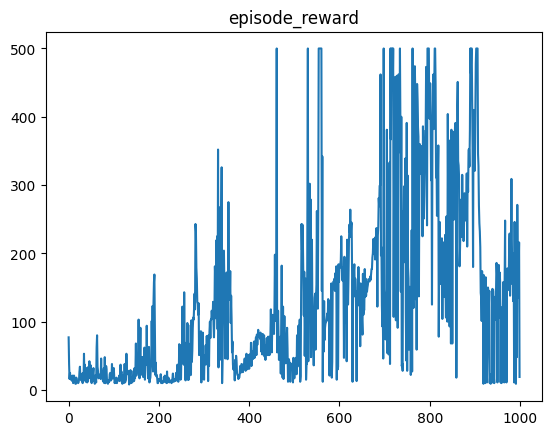

In [10]:
for k, data in metrics_history.items():
    plt.figure()
    plt.plot(data)
    plt.title(k)